In [5]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory #, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [6]:
out = util.load("outfiles/2022/test/trigger_ScoutingPFMonitor_2022-CHS.coffea")[0]

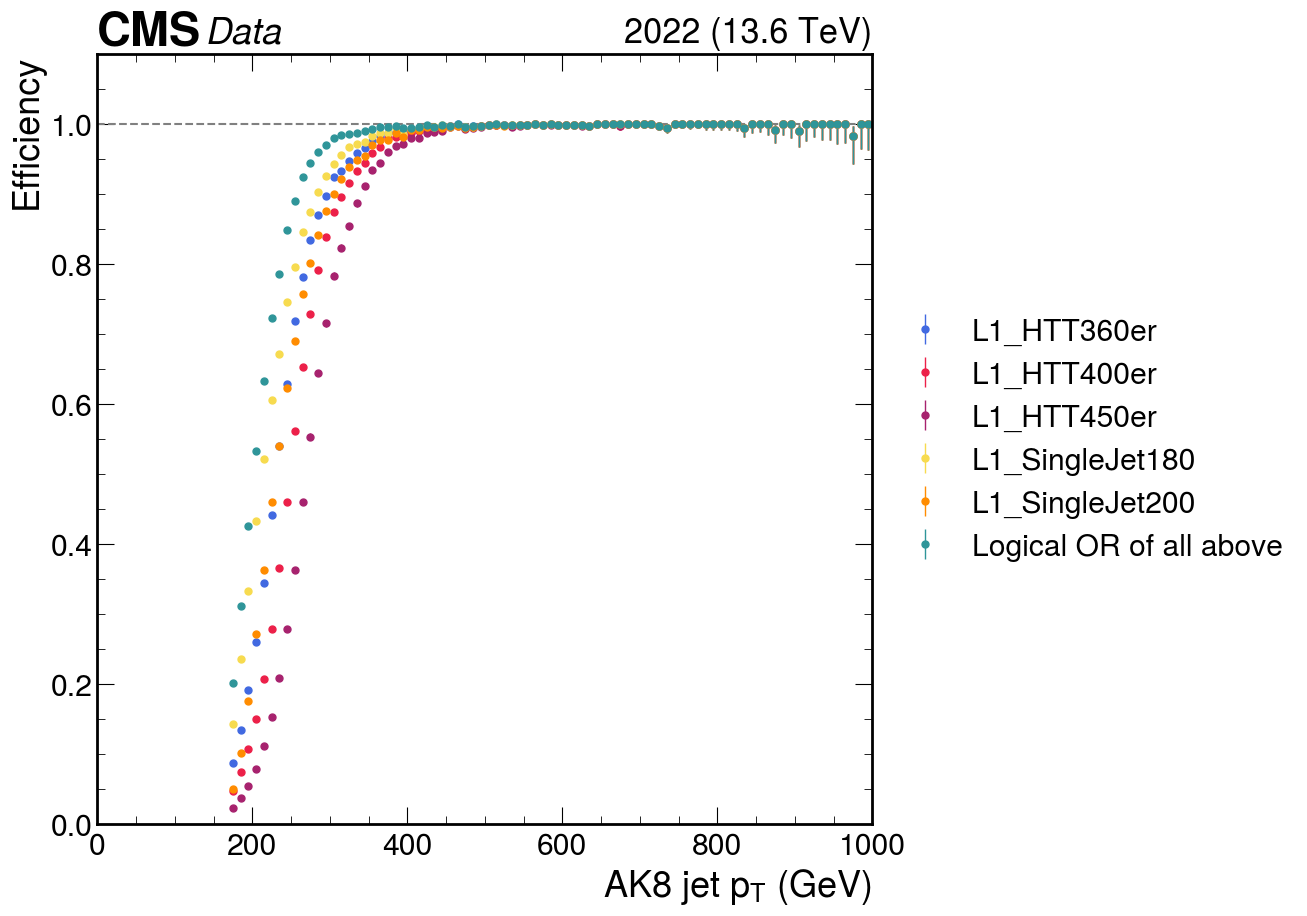

In [18]:
import warnings
warnings.filterwarnings("ignore", "invalid value encountered in divide")

for era in [""]: #C", "D", "E", "F", "G"
    
    dataset = sum if era == "" else hist.loc("2022" + era)

    fig, ax = plt.subplots(figsize=(10,10))

    colours = {
        'L1_HTT200er' : 'lightblue',
        'L1_HTT360er' : "royalblue",
        'L1_HTT450er' : "#A7226e",
        'L1_HTT400er' : "#EC2049",
        'L1_SingleJet200' : '#FF8C00',
        'L1_SingleJet180' : '#F7DB4F',
        'any': "#2F9599",
    }

    # 'L1_HTT200er', 
    triggers = ['L1_HTT360er', 'L1_HTT400er', 'L1_HTT450er', 'L1_SingleJet180', 'L1_SingleJet200', 'any']
    #triggers = ['PFHT780', 'PFHT1050', 'PFJet200', 'PFJet260', 'PFJet320', 'PFJet400', 'PFJet450', 'PFJet500', 'PFJet550', 'PFHT590', 'PFHT680', 'PFHT430', 'PFHT510', 'PFHT250', 'PFHT890', 'PFHT370', 'PFJet110', 'PFJet140', 'PFHT180', 'PFJet40', 'PFJet60', 'any']

    for trigger in triggers:

        ptproj = (
            out["ak8"]
            .project("pt", "trigger", "dataset")
        )
        denom = ptproj[:, hist.loc("none"), dataset]
        num = ptproj[:, hist.loc(trigger), dataset]

        hist_data_before, hist_bins = denom.to_numpy()
        hist_data_after, hist_bins = num.to_numpy()

        from scipy.stats import beta

        def binom_int(num, den, confint=0.68):
            quant = (1 - confint)/ 2.
            low = beta.ppf(quant, num, den - num + 1)
            high = beta.ppf(1 - quant, num + 1, den - num)
            return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

        # calculating efficiency
        efficiency = hist_data_after/hist_data_before

        # getting error band
        band_low, band_high = binom_int(hist_data_after, hist_data_before)
        error_low = efficiency - band_low
        error_high = band_high - efficiency

        # removing large errors in empty bins
        error_low[error_low == 1] = 0
        error_high[error_high == 1] = 0

        # stacking errors
        error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

        data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

        ax.errorbar(
                        num.axes[0].centers,
                        efficiency,
                        yerr=error.T,
                        color=colours[trigger],
                        label=trigger if trigger != "any" else "Logical OR of all above",
                        **data_err_opts,
                    )

    mplhep.cms.label(ax=ax, data=True, year="2022", com=13.6, label="Data")
    ax.set_xlabel(r"AK8 jet $p_T$ (GeV)")
    #ax.set_xlabel(r"$H_T$ (GeV)")
    ax.set_ylim(0, 1.1)
    ax.axhline(y=1, linestyle="--", color="gray")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("Efficiency")
    ax.set_xlim(0, 1000)

(0.0, 1000.0)

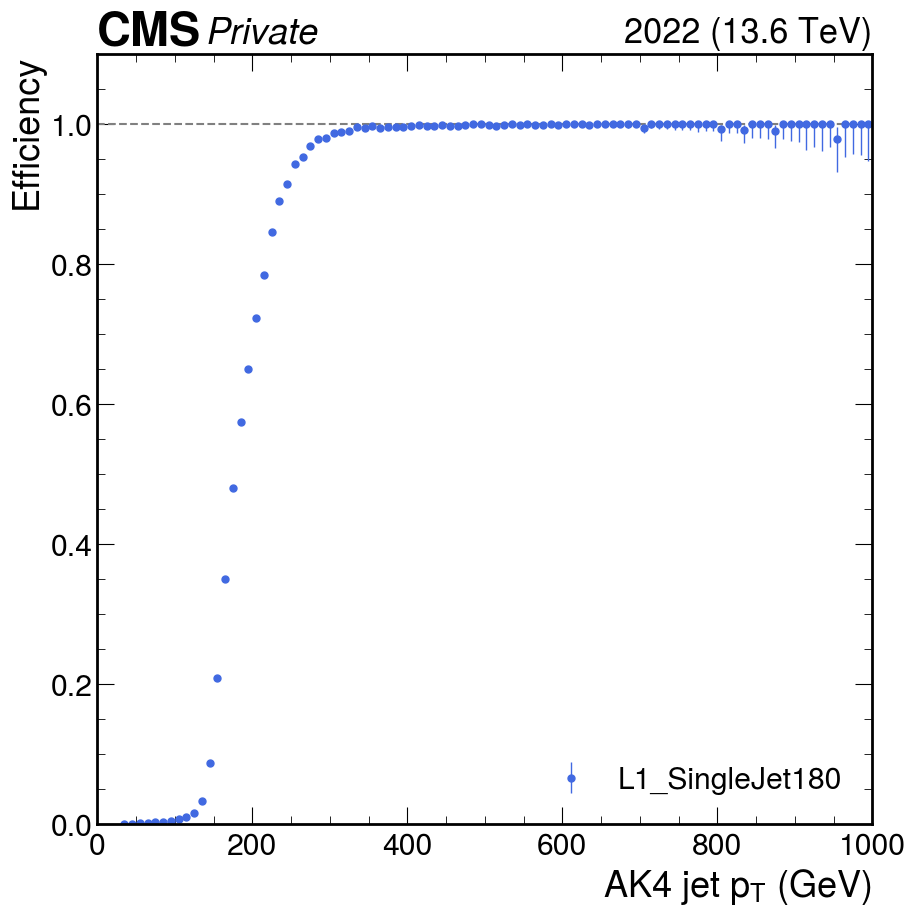

In [12]:
import warnings
warnings.filterwarnings("ignore", "invalid value encountered in divide")

out = util.load("outfiles/2022/test/trigger_ScoutingPFMonitor_2022-CHS.coffea")[0]

dataset = "2022"

fig, ax = plt.subplots(figsize=(10,10))

colours = {
    'L1_HTT360er' : "royalblue",
    'L1_HTT450er' : "#A7226e",
    'L1_HTT400er' : "#EC2049",
    'L1_SingleJet200' : '#FF8C00',
    'L1_SingleJet180' : '#F7DB4F',
    'any': "#2F9599",
}

triggers = ['L1_SingleJet180']
#triggers = ['L1_HTT360er', 'L1_HTT400er', 'L1_HTT450er', 'L1_SingleJet180', 'L1_SingleJet200', 'any']
#triggers = ['PFHT780', 'PFHT1050', 'PFJet200', 'PFJet260', 'PFJet320', 'PFJet400', 'PFJet450', 'PFJet500', 'PFJet550', 'PFHT590', 'PFHT680', 'PFHT430', 'PFHT510', 'PFHT250', 'PFHT890', 'PFHT370', 'PFJet110', 'PFJet140', 'PFHT180', 'PFJet40', 'PFJet60', 'any']

for trigger in triggers:

    ptproj = (
        out["ak4"]
        .project("pt", "trigger", "dataset")
    )
    denom = ptproj[:, hist.loc("none"), sum]
    num = ptproj[:, hist.loc(trigger), sum]

    hist_data_before, hist_bins = denom.to_numpy()
    hist_data_after, hist_bins = num.to_numpy()

    from scipy.stats import beta

    def binom_int(num, den, confint=0.68):
        quant = (1 - confint)/ 2.
        low = beta.ppf(quant, num, den - num + 1)
        high = beta.ppf(1 - quant, num + 1, den - num)
        return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

    # calculating efficiency
    efficiency = hist_data_after/hist_data_before

    # getting error band
    band_low, band_high = binom_int(hist_data_after, hist_data_before)
    error_low = efficiency - band_low
    error_high = band_high - efficiency

    # removing large errors in empty bins
    error_low[error_low == 1] = 0
    error_high[error_high == 1] = 0

    # stacking errors
    error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

    ax.errorbar(
                    num.axes[0].centers,
                    efficiency,
                    yerr=error.T,
                    color="royalblue", #colours[trigger],
                    label=trigger if trigger != "any" else "Logical OR of all above",
                    **data_err_opts,
                )

mplhep.cms.label(ax=ax, data=True, year=dataset, com=13.6, label="Private")
#ax.set_xlabel(r"$H_T$(GeV)")
ax.set_xlabel(r"AK4 jet $p_T$ (GeV)")
ax.set_ylim(0, 1.1)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(loc="best")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Efficiency")
ax.set_xlim(0, 1000)

In [5]:
#out_o = util.load("outfiles/Run3Summer22EE/offline/trigger_Muon_Run2022F_ak4ht.coffea")[0]
out_o = util.load("outfiles/Run3Summer22EE/offline/trigger_Muon_Run2022F.coffea")[0]
#out_s = util.load("outfiles/2022/trigger_ScoutingPFMonitor_2022-CHS.coffea")[0]
out_s = util.load("outfiles/Run3Summer22EE/fulllumi/trigger_ScoutingPFMonitor_Run2022F.coffea")[0]

/tmp/ipykernel_221/2740028794.py:29: RuntimeWarning: invalid value encountered in divide
  efficiency = hist_data_after/hist_data_before
/tmp/ipykernel_221/2740028794.py:29: RuntimeWarning: invalid value encountered in divide
  efficiency = hist_data_after/hist_data_before


(160.0, 1000.0)

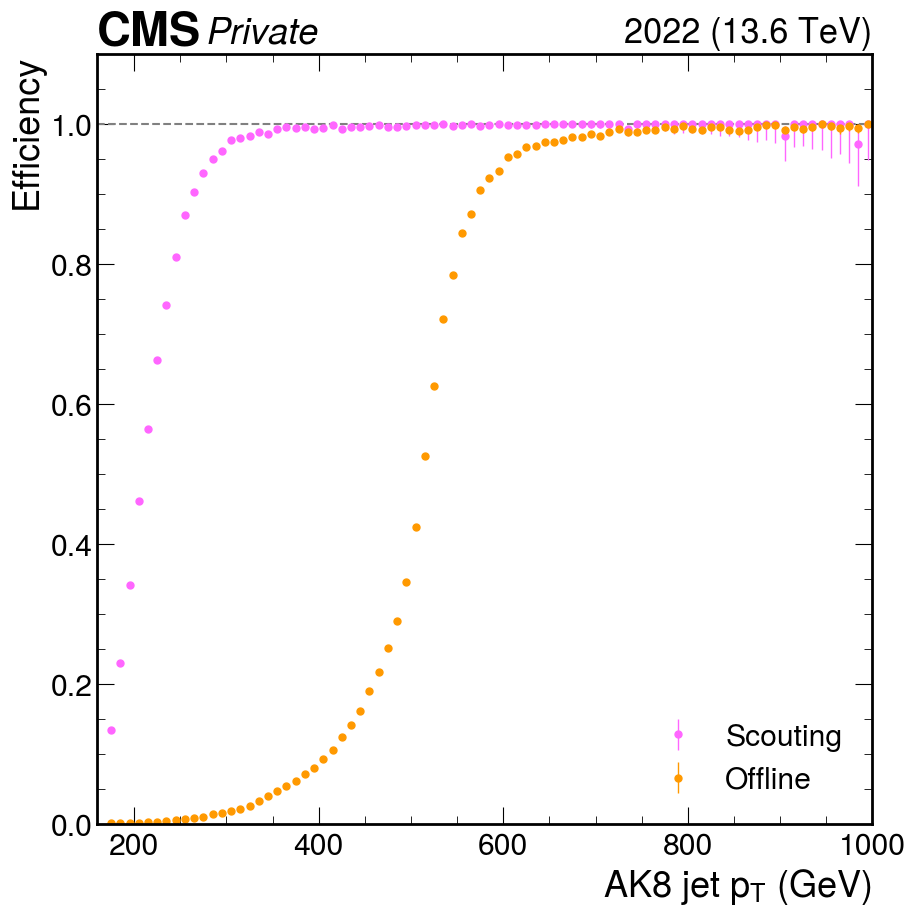

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

for rec in ["scouting", "offline"]:
    
    if rec == "scouting":
        out = out_s
    else:
        out = out_o
    
    ptproj = (
        out["ak8"]
        .project("pt", "trigger")
    )
    denom = ptproj[:, hist.loc("none")]
    num = ptproj[:, hist.loc("any")]

    hist_data_before, hist_bins = denom.to_numpy()
    hist_data_after, hist_bins = num.to_numpy()

    from scipy.stats import beta

    def binom_int(num, den, confint=0.68):
        quant = (1 - confint)/ 2.
        low = beta.ppf(quant, num, den - num + 1)
        high = beta.ppf(1 - quant, num + 1, den - num)
        return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

    # calculating efficiency
    efficiency = hist_data_after/hist_data_before

    # getting error band
    band_low, band_high = binom_int(hist_data_after, hist_data_before)
    error_low = efficiency - band_low
    error_high = band_high - efficiency

    # removing large errors in empty bins
    error_low[error_low == 1] = 0
    error_high[error_high == 1] = 0

    # stacking errors
    error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }
    
    ax.errorbar(
                num.axes[0].centers,
                efficiency,
                yerr=error.T,
                color="#FF66FF" if rec == "scouting" else "#FF9900",
                #color="#9A32CD" if rec == "scouting" else "#FF8C00",
                label="Scouting" if rec == "scouting" else "Offline",
                **data_err_opts,
            )

mplhep.cms.label(ax=ax, data=True, year="2022", com=13.6, label="Private")
ax.set_xlabel(r"AK8 jet $p_T$ (GeV)")
#ax.set_xlabel(r"$H_T$ (GeV)")

ax.set_ylim(0, 1.1)
ax.axhline(y=1, linestyle="--", color="gray")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best') #, fontsize=30)
ax.set_ylabel("Efficiency")
ax.set_xlim(160, 1000)
#ax.set_xlim(0, 2000)

# Offline

In [15]:
out = util.load("outfiles/Run3Summer22EE/offline/trigger_Muon_Run2022F.coffea")[0]

In [16]:
out

{'nevents': 332652981,
 'ak8': Hist(
   StrCategory(['Run2022F'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['none', 'any', 'PFHT780', 'PFHT1050', 'PFJet200', 'PFJet260', 'PFJet320', 'PFJet400', 'PFJet450', 'PFJet500', 'PFJet550', 'PFHT590', 'PFHT680', 'PFHT430', 'PFHT510', 'PFHT250', 'PFHT890', 'PFHT370', 'PFJet110', 'PFJet140', 'PFHT180', 'PFJet40', 'PFJet60'], growth=True, name='trigger', label='Trigger name'),
   Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
   Regular(30, 0, 300, name='mass', label='Leading jet mass'),
   Regular(100, 0, 1000, name='ht', label='Event HT'),
   storage=Double()) # Sum: 6748535.0 (9175270.0 with flow),
 'ak4': Hist(
   StrCategory(['Run2022F'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['none', 'any', 'PFHT780', 'PFHT1050', 'PFJet200', 'PFJet260', 'PFJet320', 'PFJet400', 'PFJet450', 'PFJet500', 'PFJet550', 'PFHT590', 'PFHT680', 'PFHT430', 'PFHT510', 'PFHT250', 'PFHT890', 'PFHT370', 'PFJ

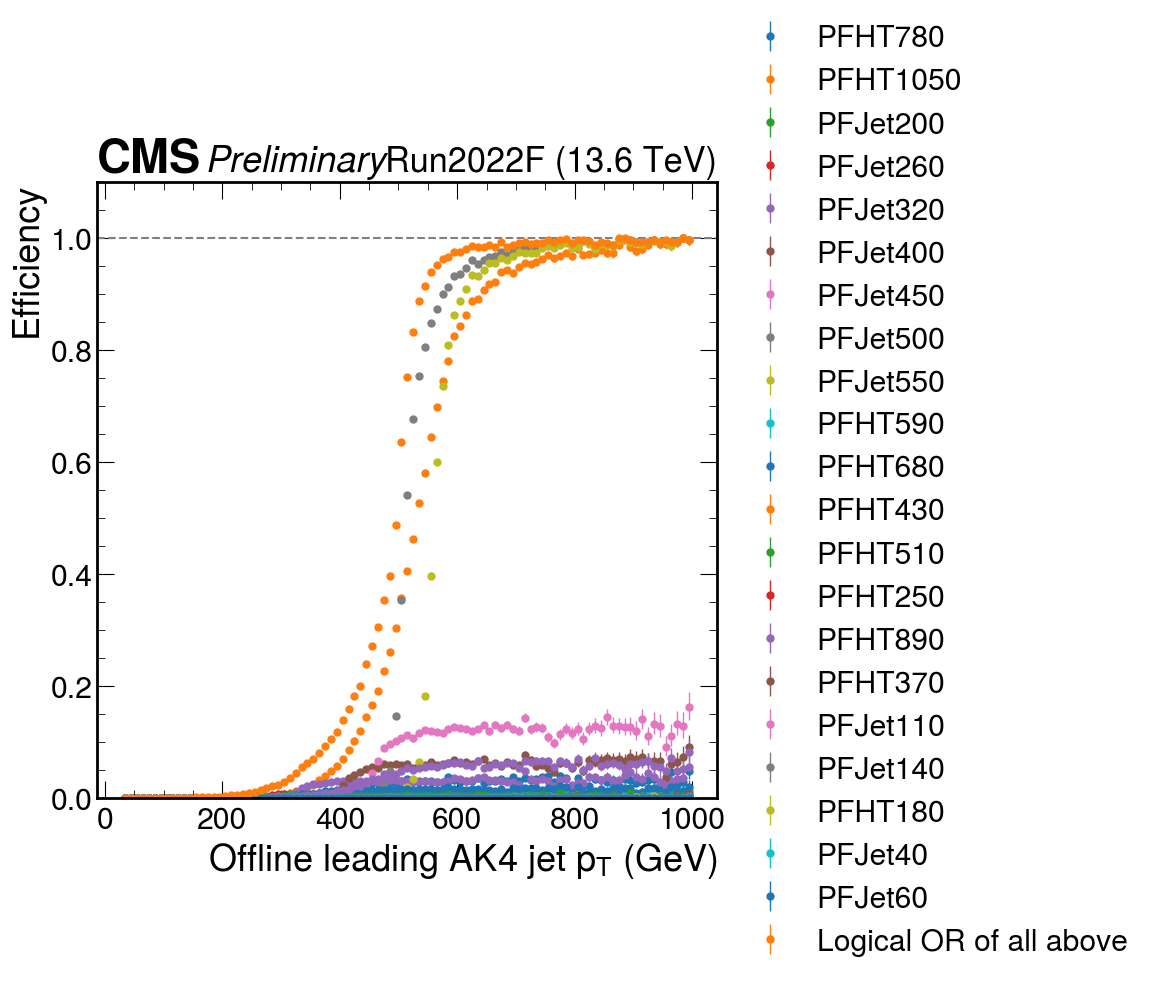

In [17]:
import warnings
warnings.filterwarnings("ignore", "invalid value encountered in divide")

for era in ["F"]:
    
    dataset = "Run2022" + era

    fig, ax = plt.subplots(figsize=(8,8))

    triggers = ['PFHT780', 'PFHT1050', 'PFJet200', 'PFJet260', 'PFJet320', 'PFJet400', 'PFJet450', 'PFJet500', 'PFJet550', 'PFHT590', 'PFHT680', 'PFHT430', 'PFHT510', 'PFHT250', 'PFHT890', 'PFHT370', 'PFJet110', 'PFJet140', 'PFHT180', 'PFJet40', 'PFJet60', 'any']

    for trigger in triggers:

        ptproj = (
            out["ak4"]
            .project("pt", "trigger", "dataset")
        )
        denom = ptproj[:, hist.loc("none"), hist.loc(dataset)]
        num = ptproj[:, hist.loc(trigger), hist.loc(dataset)]

        hist_data_before, hist_bins = denom.to_numpy()
        hist_data_after, hist_bins = num.to_numpy()

        from scipy.stats import beta

        def binom_int(num, den, confint=0.68):
            quant = (1 - confint)/ 2.
            low = beta.ppf(quant, num, den - num + 1)
            high = beta.ppf(1 - quant, num + 1, den - num)
            return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

        # calculating efficiency
        efficiency = hist_data_after/hist_data_before

        # getting error band
        band_low, band_high = binom_int(hist_data_after, hist_data_before)
        error_low = efficiency - band_low
        error_high = band_high - efficiency

        # removing large errors in empty bins
        error_low[error_low == 1] = 0
        error_high[error_high == 1] = 0

        # stacking errors
        error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

        data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

        ax.errorbar(
                        num.axes[0].centers,
                        efficiency,
                        yerr=error.T,
                        #color=colours[trigger],
                        label=trigger if trigger != "any" else "Logical OR of all above",
                        **data_err_opts,
                    )

    mplhep.cms.label(ax=ax, data=True, year=dataset, com=13.6, label="Preliminary")
    ax.set_xlabel(r"Offline leading AK4 jet $p_T$ (GeV)")
    ax.set_ylim(0, 1.1)
    ax.axhline(y=1, linestyle="--", color="gray")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("Efficiency")
    #ax.set_xlim(0, 1500)

# Dijet

In [11]:
data = util.load("outfiles/2022/trigger_dijet_ScoutingPFMonitor_2022-CHS.coffea")[0]
mc = util.load("outfiles/2022/trigger_dijet_QCD_PT-15to7000_TuneCP5_13p6TeV_pythia8.coffea")[0]

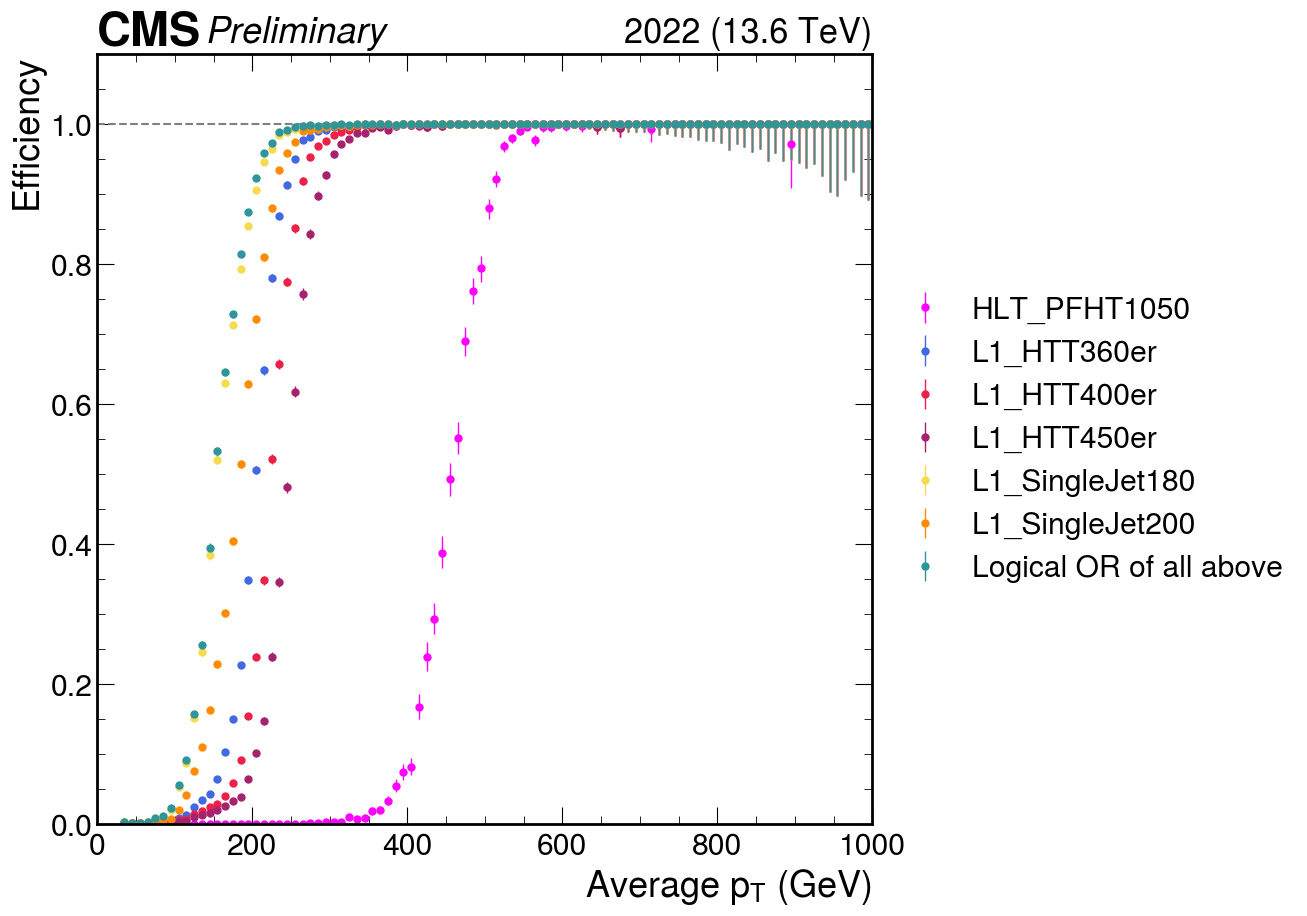

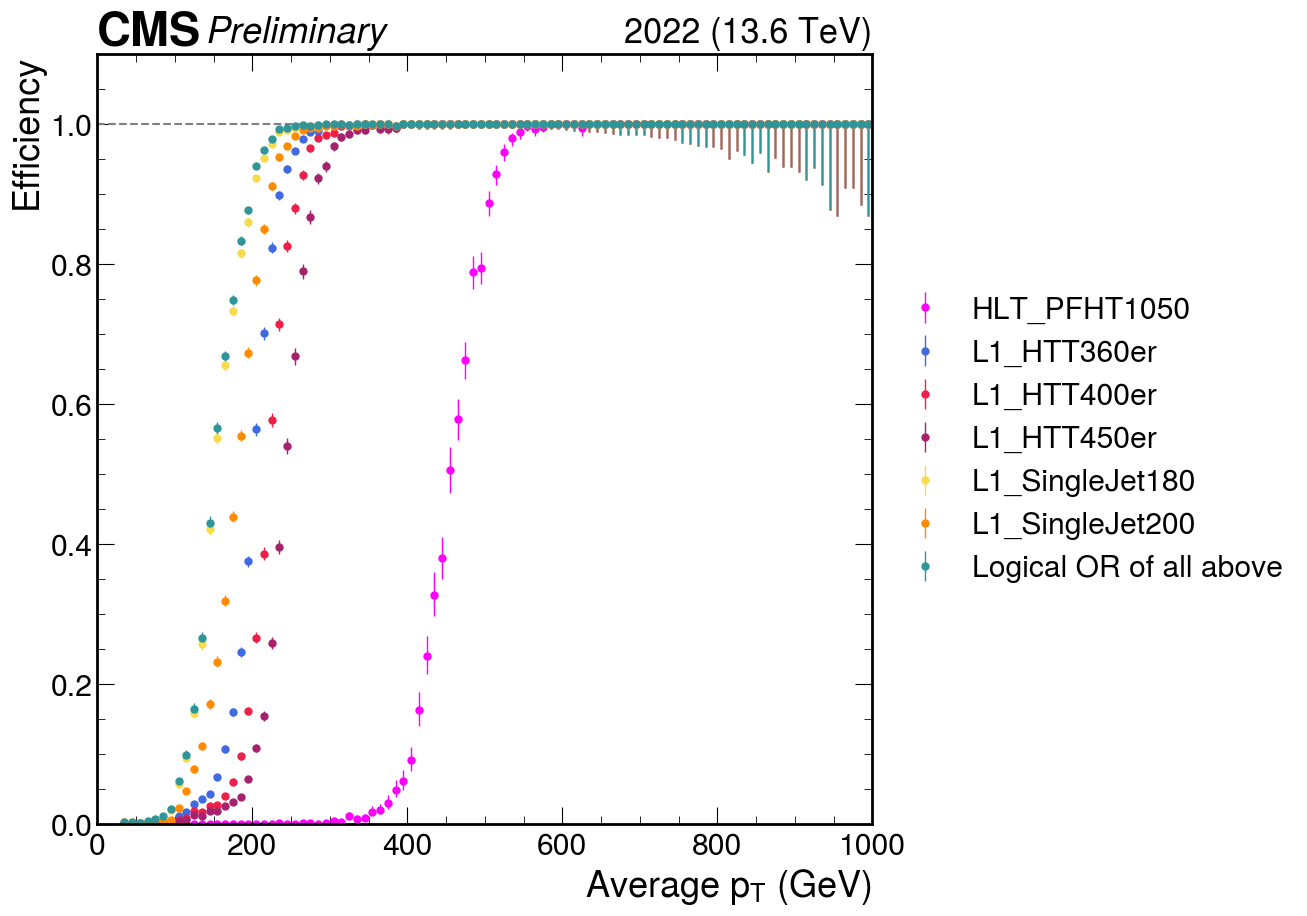

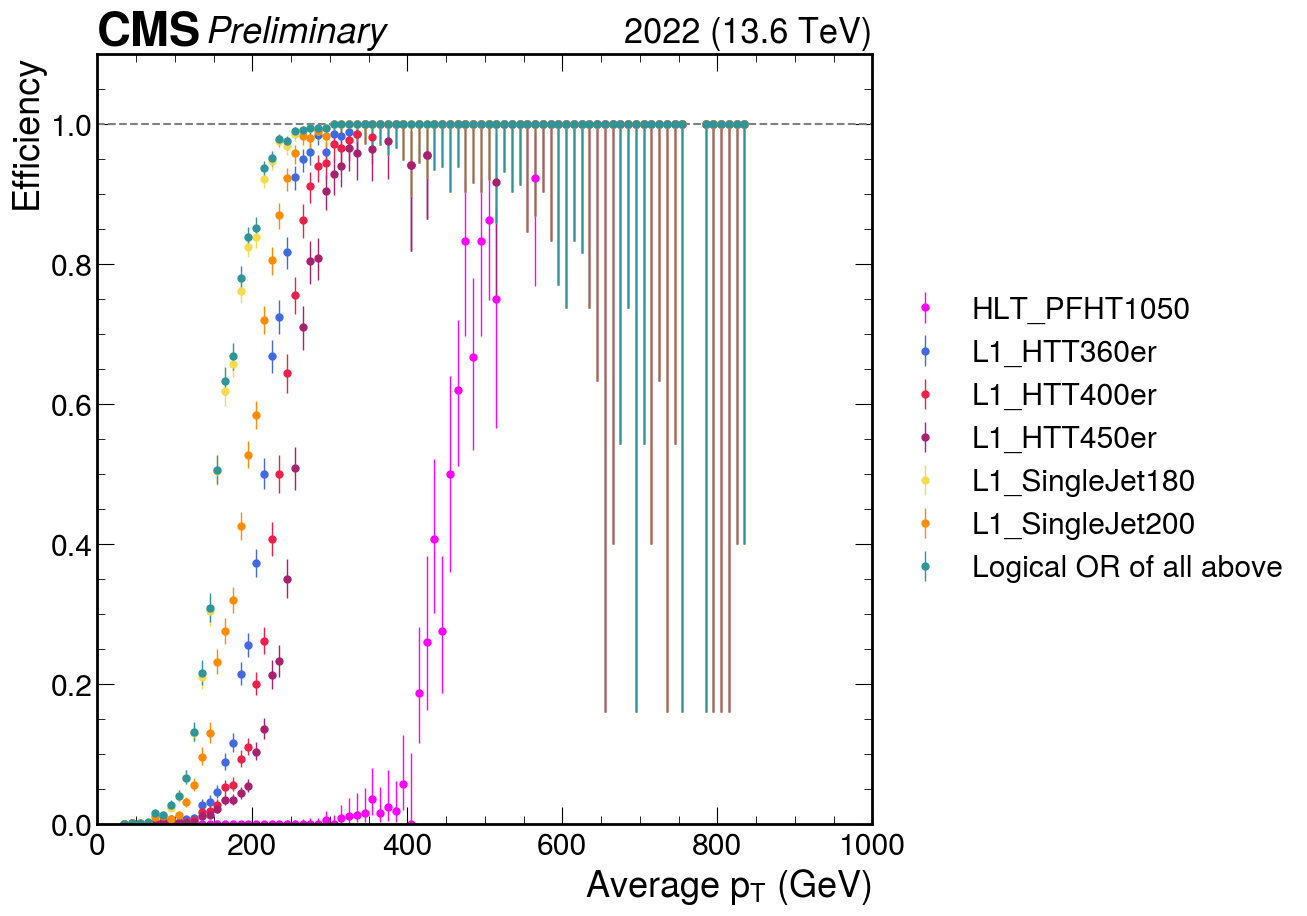

In [20]:
import warnings
warnings.filterwarnings("ignore", "invalid value encountered in divide")

dataset = "2022"

colours = {
    'HLT_PFHT1050' : 'fuchsia',
    'L1_HTT360er' : "royalblue",
    'L1_HTT450er' : "#A7226e",
    'L1_HTT400er' : "#EC2049",
    'L1_SingleJet200' : '#FF8C00',
    'L1_SingleJet180' : '#F7DB4F',
    'any': "#2F9599",
}

eta = {
    0 : r"$|\eta| \leq 1.3$",
    1 : r"$1.3 < |\eta| \leq 2.5$",
    sum : r"$|\eta| \leq 2.5$",
}

triggers = ['HLT_PFHT1050','L1_HTT360er', 'L1_HTT400er', 'L1_HTT450er', 'L1_SingleJet180', 'L1_SingleJet200', 'any']

for isData, out in [(True, data)]: #, (False, mc)]:
    
    for eta1, eta2 in [(sum, sum), (0, 0), (1, 1)]:

        fig, ax = plt.subplots(figsize=(10,10))

        for trigger in triggers:

            ptproj = (
                out["ak4"]
                .project("pt", "trigger", "dataset", "eta1", "eta2")
            )
            denom = ptproj[:, hist.loc("none"), sum, eta1, eta2]
            num = ptproj[:, hist.loc(trigger), sum, eta1, eta2]

            hist_data_before, hist_bins = denom.to_numpy()
            hist_data_after, hist_bins = num.to_numpy()

            from scipy.stats import beta

            def binom_int(num, den, confint=0.68):
                quant = (1 - confint)/ 2.
                low = beta.ppf(quant, num, den - num + 1)
                high = beta.ppf(1 - quant, num + 1, den - num)
                return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

            # calculating efficiency
            efficiency = hist_data_after/hist_data_before

            # getting error band
            band_low, band_high = binom_int(hist_data_after, hist_data_before)
            error_low = efficiency - band_low
            error_high = band_high - efficiency

            # removing large errors in empty bins
            error_low[error_low == 1] = 0
            error_high[error_high == 1] = 0

            # stacking errors
            error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

            data_err_opts = {
                    'linestyle': 'none',
                    'marker': '.',
                    'markersize': 10.,
                    'elinewidth': 1,
                }

            ax.errorbar(
                            num.axes[0].centers,
                            efficiency,
                            yerr=error.T,
                            color=colours[trigger],
                            label=trigger if trigger != "any" else "Logical OR of all above",
                            **data_err_opts,
                        )

        mplhep.cms.label(ax=ax, data=True if isData else False, year=dataset, com=13.6, label="Preliminary" if isData else "")
        ax.set_xlabel(r"Average $p_T$ (GeV)")
        ax.set_ylim(0, 1.1)
        ax.axhline(y=1, linestyle="--", color="gray")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #, title=eta[eta1],
        ax.set_ylabel("Efficiency")
        ax.set_xlim(0, 1000)